In [1]:
# !pip install sentence-transformers
# reference: https://medium.com/ilb-labs-publications/fine-tuning-bert-for-a-regression-task-is-a-description-enough-to-predict-a-propertys-list-price-cf97cd7cb98a

In [1]:
# Import libraries/frameworks
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
from torch.nn.utils.clip_grad import clip_grad_norm
from sklearn.preprocessing import StandardScaler

# Read data into a pandas dataframe
df = pd.read_excel( 'train_final.xlsx' )
df.fillna(0, inplace=True)
df.head(2)

,ItemNum,ItemStem_Text,Answer__A,Answer__B,Answer__C,Answer__D,Answer__E,Answer__F,Answer__G,Answer__H,Answer__I,Answer__J,Answer_Key,Answer_Text,ItemType,EXAM,Difficulty,Response_Time
0,91,"Over 1 year, a study is conducted to assess th...",Case-control study,Crossover study,Open-labeled clinical trial,Randomized clinical trial,"Single-blind, randomized, controlled trial",0,0,0,0,0,C,Open-labeled clinical trial,Text,STEP 1,0.86,111.21
1,288,A previously healthy 52-year-old woman comes t...,Calcitriol production by activated macrophages,Local resorption of bone by metastases,Parathyroid hormone-related peptide secretion,Secretion of parathyroid hormone,Secretion of thyroid-stimulating hormone,0,0,0,0,0,A,Calcitriol production by activated macrophages,Text,STEP 1,0.44,83.94


Text(0.5, 0, 'Number of words')

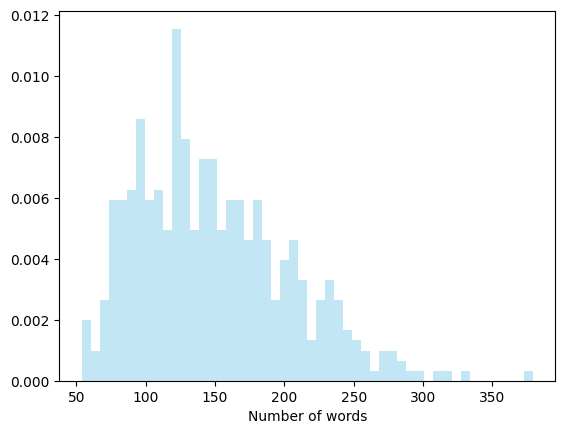

In [3]:
selected_cols = ['ItemStem_Text', 'Answer__A', 'Answer__B', 'Answer__C', 'Answer__D', 'Answer__E', 'Answer__F', 'Answer__G', 'Answer__H',
              'Answer__I', 'Answer__J', 'Answer_Text' ]
df[selected_cols] = df[selected_cols].astype('str')
text_input = []
text_corpus = []
for ind, row in df.iterrows():
    text, text_ = [], ''
    for col in selected_cols:
        if row[col] != 0 :
            text += row[col].split()
            text_ += ' ' + row[col]
    text_input.append( text )
    text_corpus.append( text_ )

lengths = [ len(text) for text in text_input ]
plt.hist(lengths, bins=50, density=True, alpha=0.5, color='skyblue');
plt.xlabel('Number of words')

In [4]:
max(lengths), len(text_corpus)

(379, 466)

In [5]:
def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
    return dataloader

class bertRegressor(nn.Module):

    def __init__(self, drop_rate=0.2, freeze_bert=False):

        super(bertRegressor, self).__init__()
        D_in, D_out = 768, 1
        self.bert = AutoModel.from_pretrained('microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract')
        self.regressor = nn.Sequential(
                                        nn.Dropout(drop_rate),
                                        nn.Linear(D_in, D_out))

    def forward(self, input_ids, attention_masks):

        outputs = self.bert(input_ids, attention_masks)
        class_label_output = outputs[1]
        outputs = self.regressor(class_label_output)
        return outputs

def train(model, optimizer, scheduler, loss_function, epochs, train_dataloader, device, clip_value=2):

    for epoch in range(epochs):
        print(epoch)
        print("-----")
        best_loss = 1e10
        model.train()

        for step, batch in tqdm(enumerate(train_dataloader)):
            batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)
            loss = loss_function(outputs.squeeze(), batch_labels.squeeze())
            loss.backward()
            clip_grad_norm(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()

    return model

# ref: https://discuss.pytorch.org/t/rmse-loss-function/16540/3
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))
loss_function = RMSELoss

def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks, _ = tuple(b.to(device) for b in batch)

        with torch.no_grad():
            output += model(batch_inputs, batch_masks).view(1,-1).tolist()[0]
    return output

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

tokenizer = AutoTokenizer.from_pretrained('microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract')

# Tokenize sentences
encoded_corpus = tokenizer(text_corpus, padding=True, truncation=True, return_tensors='pt', max_length=400)
input_ids, attention_mask = encoded_corpus['input_ids'], encoded_corpus['attention_mask']

# Define labels
labels_difficulty = df['Difficulty'].to_numpy()
labels_response_time = df['Response_Time'].to_numpy()

Using GPU.


### **Task 1: Predict Difficulty**

In [6]:
test_size = 0.1
seed = 42

train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels_difficulty, test_size=test_size, random_state=seed)
train_masks, test_masks, _, _ = train_test_split(attention_mask, labels_difficulty, test_size=test_size, random_state=seed)

batch_size = 8
train_dataloader = create_dataloaders(train_inputs, train_masks, train_labels, batch_size)
test_dataloader = create_dataloaders(test_inputs, test_masks, test_labels, batch_size)

model = bertRegressor(drop_rate=0.2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

model = train(model, optimizer, scheduler, loss_function, epochs, train_dataloader, device, clip_value=2)

y_pred = predict(model, test_dataloader, device)

# compute rmse
mean_squared_error( test_labels, y_pred, squared=False )

C:\Users\rishikesh\AppData\Local\Temp\ipykernel_3344\1685244855.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(inputs)
C:\Users\rishikesh\AppData\Local\Temp\ipykernel_3344\1685244855.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_tensor = torch.tensor(masks)
D:\Anaconda\envs\llmenv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


0
-----


0it [00:03, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 60.00 MiB (GPU 0; 4.00 GiB total capacity; 3.34 GiB already allocated; 0 bytes free; 3.49 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### **Task 2: Predict Response Time**

In [ ]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels_response_time, test_size=test_size, random_state=seed)
train_masks, test_masks, _, _ = train_test_split(attention_mask, labels_response_time, test_size=test_size, random_state=seed)

scaler = StandardScaler()
scaler.fit(train_labels.reshape(-1, 1))
train_labels = scaler.transform(train_labels.reshape(-1, 1))
test_labels = scaler.transform(test_labels.reshape(-1, 1))

batch_size = 8
train_dataloader = create_dataloaders(train_inputs, train_masks, train_labels, batch_size)
test_dataloader = create_dataloaders(test_inputs, test_masks, test_labels, batch_size)

model = bertRegressor(drop_rate=0.2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

model = train(model, optimizer, scheduler, loss_function, epochs, train_dataloader, device, clip_value=2)

y_pred_scaled = predict(model, test_dataloader, device)

In [ ]:
y_pred_scaled = np.array(y_pred_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

# compute rmse
mean_squared_error( test_labels, y_pred, squared=False )